In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

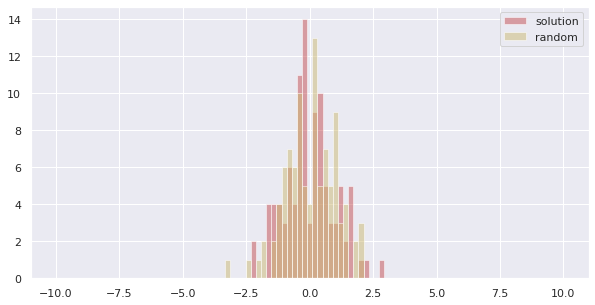

In [9]:
plt.figure(figsize = (10, 5))
bins = np.linspace(-10, 10, 100)

solution = np.random.randn(100)
w = np.random.randn(100)

plt.hist(solution, bins, alpha = 0.5, label = 'solution', color = 'r')
plt.hist(w, bins, alpha = 0.5, label = 'random', color = 'y')
plt.legend()
plt.show()

In [10]:
def f(w):
    return -np.sum(np.square(solution - w))


npop = 50
sigma = 0.1
alpha = 0.001

for i in range(5000):

    if (i + 1) % 1000 == 0:
        print(
            'iter %d. w: %s, solution: %s, reward: %f'
            % (i + 1, str(w[-1]), str(solution[-1]), f(w))
        )
    N = np.random.randn(npop, 100)
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma * N[j]
        R[j] = f(w_try)

    A = (R - np.mean(R)) / np.std(R)
    w = w + alpha / (npop * sigma) * np.dot(N.T, A)

iter 1000. w: -0.5617010123811547, solution: -0.2743529074320583, reward: -12.694795
iter 2000. w: -0.28023153267316975, solution: -0.2743529074320583, reward: -0.007935
iter 3000. w: -0.2696749266060992, solution: -0.2743529074320583, reward: -0.006470
iter 4000. w: -0.268573974533994, solution: -0.2743529074320583, reward: -0.007935
iter 5000. w: -0.2806765455465561, solution: -0.2743529074320583, reward: -0.008532


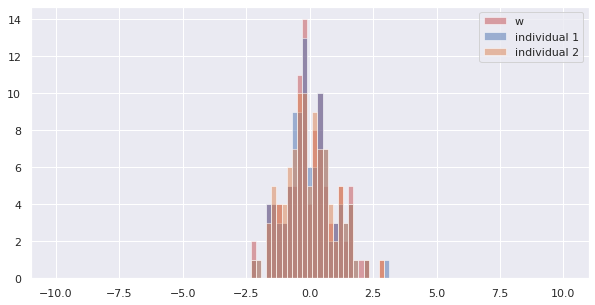

In [11]:
plt.figure(figsize=(10,5))

sigma = 0.1
N = np.random.randn(npop, 100)
individuals = []
for j in range(2):
    individuals.append(w + sigma * N[j])
    
    
plt.hist(w, bins, alpha=0.5, label='w',color='r')
plt.hist(individuals[0], bins, alpha=0.5, label='individual 1')
plt.hist(individuals[1], bins, alpha=0.5, label='individual 2')
plt.legend()
plt.show()

In [12]:
import pandas as pd
google = pd.read_csv('/content/GOOG.csv')
google.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-07,1365.939941,1377.599976,1355.270020,1372.560059,1372.560059,1397600
1,2020-05-08,1383.130005,1398.760010,1375.479980,1388.369995,1388.369995,1386900
2,2020-05-11,1378.280029,1416.530029,1377.151978,1403.260010,1403.260010,1412100
3,2020-05-12,1407.119995,1415.000000,1374.770020,1375.739990,1375.739990,1390600
4,2020-05-13,1377.050049,1385.482056,1328.400024,1349.329956,1349.329956,1812600


In [13]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [14]:
close = google.Close.values.tolist()
get_state(close, 0, 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [16]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [17]:
window_size = 30
model = Model(window_size, 500, 3)

In [18]:
initial_money = 10000
starting_money = initial_money
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []
quantity = 0

max_buy = 5
max_sell = 5


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        if buy < 0:
            buy = 1
        if buy > max_buy:
            buy_units = max_buy
        else:
            buy_units = buy
        total_buy = buy_units * close[t]
        initial_money -= total_buy
        inventory.append(total_buy)
        quantity += buy_units
    elif action == 2 and len(inventory) > 0:
        if quantity > max_sell:
            sell_units = max_sell
        else:
            sell_units = quantity
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell

    state = next_state
((initial_money - starting_money) / starting_money) * 100

-105.11498655000003

In [19]:
import time


class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [20]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(
    model = model,
    money = 10000,
    max_buy = 5,
    max_sell = 5,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [21]:
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 106.100388
iter 20. reward: 107.794637
iter 30. reward: 115.506848
iter 40. reward: 116.966981
iter 50. reward: 129.815497
iter 60. reward: 129.650709
iter 70. reward: 141.232582
iter 80. reward: 150.175890
iter 90. reward: 149.234691
iter 100. reward: 158.569398
iter 110. reward: 169.844987
iter 120. reward: 174.246997
iter 130. reward: 167.262629
iter 140. reward: 176.946935
iter 150. reward: 182.216200
iter 160. reward: 181.317703
iter 170. reward: 185.298013
iter 180. reward: 189.222761
iter 190. reward: 178.196736
iter 200. reward: 190.560536
iter 210. reward: 187.456641
iter 220. reward: 194.494635
iter 230. reward: 186.507143
iter 240. reward: 198.095338
iter 250. reward: 226.481948
iter 260. reward: 216.161629
iter 270. reward: 223.094387
iter 280. reward: 206.751245
iter 290. reward: 236.412449
iter 300. reward: 233.086837
iter 310. reward: 230.011342
iter 320. reward: 230.085399
iter 330. reward: 227.936710
iter 340. reward: 215.217606
iter 350. reward: 231.7

day 3: buy 1 units at price 1375.739990, total balance 8624.260010
day 6: buy 1 units at price 1373.189941, total balance 7251.070069
day 7: buy 1 units at price 1383.939941, total balance 5867.130128
day 8: buy 5 units at price 6867.424925, total balance -1000.294797
day 13, sell 5 units at price 7089.199830, investment 415.300848 %, total balance 6088.905033,
day 14: buy 5 units at price 7083.649900, total balance -994.744867
day 17, sell 5 units at price 7196.099855, investment 424.042570 %, total balance 6201.354988,
day 20, sell 3 units at price 4315.170045, investment 211.803274 %, total balance 10516.525033,
day 24: buy 5 units at price 7019.199830, total balance 3497.325203
day 25: buy 5 units at price 7065.900270, total balance -3568.575067
day 27, sell 5 units at price 7213.599855, investment 2.769547 %, total balance 3645.024788,
day 28, sell 5 units at price 7255.599975, investment 2.684721 %, total balance 10900.624763,
day 33: buy 5 units at price 7159.849855, total balan

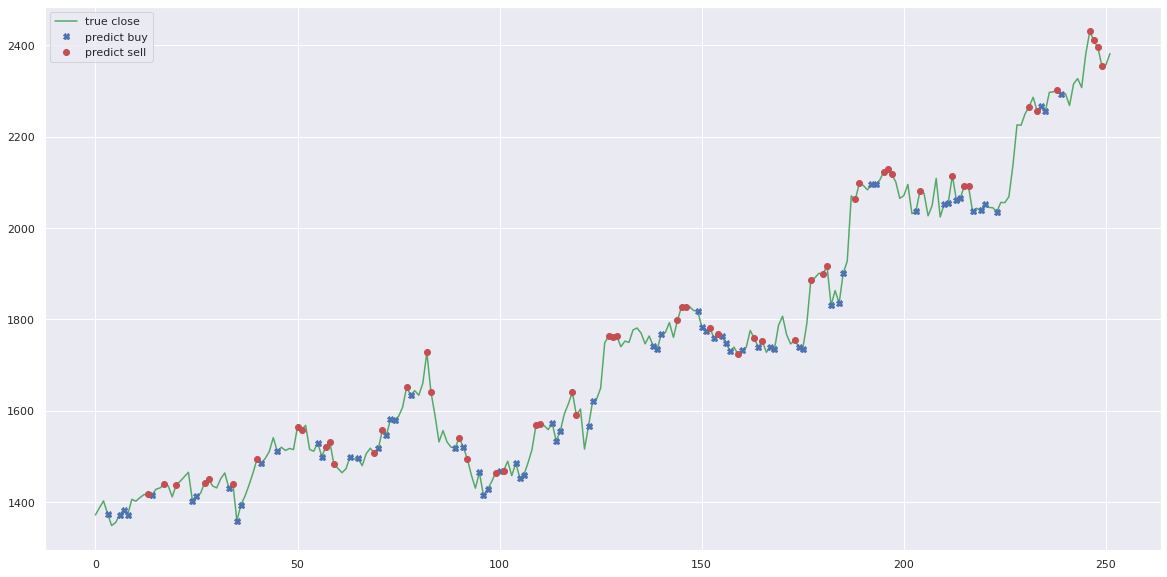

In [22]:
agent.buy()